# Optimization with Bregman Divergences : Project
## Duchemin Quentin

# 1) RL algorithms using KL divergence as approximation of Mirror Descent algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from renderer import *
from gridworld import *

import scipy
import scipy.optimize as opt
import pdb

In [2]:
grid1 = [
    ['', '', '', 1],
    ['', 'x', '', -1],
    ['', '', '', '']
]

env = GridWorld(gamma=0.95, grid=grid1)

In [3]:
class Policy(object):
    def __init__(self,pi):
        n_states,n_actions = np.shape(pi)
        self.n_actions = n_actions
        self.n_states = n_states
        self.pi = pi
    def draw_action(self,state):
        u = np.random.rand()
        probas = np.cumsum(self.pi[state,:])
        a = 0
        while (a < self.n_actions-1 and (u > probas[a] or self.pi[state,a]==0)):
            a += 1
        return a

In [4]:
class RLModel:
    def __init__(self, env):
        self.env = env
        
    def initialize_pi(self):
        pi = np.zeros((self.env.n_states,self.env.n_actions))
        for s in range(self.env.n_states):
            actions = self.env.state_actions[s]
            for a in actions:
                pi[s,a] = 1./len(actions)
        return pi
    
    def collect_episodes(self, policy=None, horizon=None, n_episodes=1, render=False):
        paths = []

        for _ in range(n_episodes):
            observations = []
            actions = []
            rewards = []
            next_states = []
            ep_r = 0
            state = self.env.reset()
            for _ in range(horizon):
                action = policy.draw_action(state)
                next_state, reward, terminal = self.env.step(state,action)
                ep_r += reward
                if render:
                    self.env.render()
                observations.append(state)
                actions.append(action)
                rewards.append(reward)
                next_states.append(next_state)
                state = copy.copy(next_state)
                if terminal:
                    if len(self.moving_rewards) == 0:  # record running episode reward
                        self.moving_rewards.append(ep_r)
                    else:
                        self.moving_rewards.append(0.9 * self.moving_rewards[-1] + 0.1 * ep_r)
                    # Finish rollout if terminal state reached
                    break
                    # We need to compute the empirical return for each time step along the
                    # trajectory
            paths.append(dict(
                states=np.array(observations),
                actions=np.array(actions),
                rewards=np.array(rewards),
                next_states=np.array(next_states)
            ))
        return paths

    
    def render_policy(self):
        render_policy(self.env,self.policy.pi)

## a) REPS algorithm

In [5]:
class REPS(RLModel):
    def __init__(self, env, p=3, N=100,K=50,eta=0.1):
        RLModel.__init__(self, env)
        self.p = p
        self.N = N
        self.K = K
        self.eta = eta
        self.moving_rewards = []
    
    def compute_new_policy(self, eta, policy, phi, theta, samples):
        log_new_pi = np.zeros((policy.n_states,policy.n_actions))
        A = np.zeros((policy.n_states,policy.n_actions))
        counter = np.zeros((policy.n_states,policy.n_actions))
        nb_samples = 0
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            for j in range(len(states)):
                A[states[j],actions[j]] += rewards[j] + np.dot(phi[next_states[j],:],theta) - np.dot(phi[states[j],:],theta)
                counter[states[j],actions[j]] += 1
                nb_samples += 1
        for s in range(env.n_states):
            for a in range(env.n_actions):
                if counter[s,a]!=0:
                    A[s,a] /= counter[s,a]
        for s in range(policy.n_states):
            for a in range(policy.n_actions):
                argexpo = np.zeros(policy.n_actions)
                if policy.pi[s,a] == 0:
                    log_new_pi[s,a] = -float('inf')
                else:
                    for b in range(policy.n_actions):
                        argexpo[b] = np.log(policy.pi[s,b]+0.0001) + eta * A[s,b]
                    maxi = np.max(argexpo)
                    log_new_pi[s,a] = argexpo[a] - np.log(np.sum(np.exp(argexpo - maxi))) - maxi
        return(Policy(np.exp(log_new_pi)))


    def g(self, theta, eta, phi, samples):
        res = 0
        A = np.zeros((env.n_states,env.n_actions))
        counter = np.zeros((env.n_states,env.n_actions))
        nb_samples = 0
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            for j in range(len(states)):
                A[states[j],actions[j]] += rewards[j] + np.dot(phi[next_states[j],:],theta) - np.dot(phi[states[j],:],theta)
                counter[states[j],actions[j]] += 1
                nb_samples += 1
        for s in range(env.n_states):
            for a in range(env.n_actions):
                if counter[s,a]!=0:
                    A[s,a] /= counter[s,a]
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            for j in range(len(states)):
                res += np.exp(eta*A[states[j],actions[j]])
        res /= nb_samples
        return (np.log(res)/eta)

    def Dg(self, theta, eta, phi, samples):
        n_states,p = np.shape(phi)
        numerator = 0
        denominator = 0
        A = np.zeros((env.n_states,env.n_actions))
        D = np.zeros((env.n_states,env.n_actions,p))
        counter = np.zeros((env.n_states,env.n_actions))
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            for j in range(len(states)):
                A[states[j],actions[j]] += rewards[j] + np.dot(phi[next_states[j],:],theta) - np.dot(phi[states[j],:],theta)
                D[states[j],actions[j],:] += phi[next_states[j],:] - phi[states[j],:]
                counter[states[j],actions[j]] += 1
        for s in range(env.n_states):
            for a in range(env.n_actions):
                if counter[s,a]!=0:
                    A[s,a] /= counter[s,a]
        for s in range(env.n_states):
            for a in range(env.n_actions):
                if counter[s,a]!=0:
                    D[s,a,:] /= counter[s,a]
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            for j in range(len(states)):
                numerator += np.exp(eta*A[states[j],actions[j]]) * D[states[j],actions[j]]
                denominator += np.exp(eta*A[states[j],actions[j]])
        return ((1/eta) * numerator / denominator)

    def compute_phi(self,p):
        phi = np.zeros((self.env.n_states,p))
        for k in range(self.env.n_states):
            phi[k,:] = [k,k**2,np.log(k+1)]
        return phi

    def policy_update(self):
        """Relative Entropy Policy Search using Mirror Descent"""
        p = 3    
        # initialization of the distribution
        pi = self.initialize_pi()
        policy = Policy(pi)
        #Tmax =  -100*np.log(10e-6)/(1-env.gamma)
        T = 100
        theta = [0 for i in range(p)]
        phi = self.compute_phi(p)
        
        for k in tqdm(range(self.K), desc="Iterating REPS algorithm..."):
            ##### SAMPLING
            samples = self.collect_episodes(policy=policy,horizon=T,n_episodes=self.N)

            #### OPTIMIZE
            theta = opt.fmin_bfgs(self.g,x0=theta,fprime=self.Dg,args=(self.eta,phi,samples), disp=0)

            #### COMPUTE THE NEW POLICY
            policy = self.compute_new_policy(self.eta,policy,phi,theta,samples) 
            
            
        self.policy = policy
        self.theta = theta
        self.phi = phi

In [6]:
REPS_model = REPS(env,K=100)
REPS_model.policy_update()

Iterating REPS algorithm...: 100%|███████████████████████████████████████████████████| 100/100 [24:09<00:00, 16.56s/it]


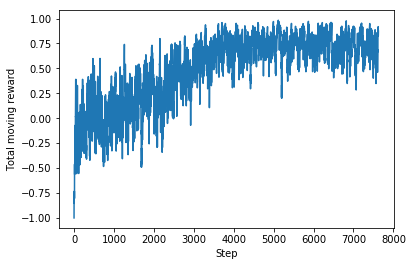

In [7]:
avg_moving_reward = REPS_model.moving_rewards
plt.plot(np.arange(len(avg_moving_reward)), avg_moving_reward)
plt.xlabel('Step')
plt.ylabel('Total moving reward')
plt.show()

In [8]:
REPS_model.render_policy()

## b) TRPO algorithm

In [9]:
class TRPO(RLModel):
    def __init__(self, env, K=200, N = 100, eta=0.1):
        RLModel.__init__(self, env)
        self.K = K
        self.N = N
        self.eta = eta
        self.moving_rewards = []

    def compute_Q(self, samples, Q):
        n_states,n_actions = np.shape(Q)
        counter = np.zeros((n_states,n_actions))
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            cumulated_rwd = 0
            for j in range(len(states)):
                t = len(states) -1 - j
                cumulated_rwd = self.env.gamma * cumulated_rwd + rewards[t]
                Q[states[t],actions[t]] += cumulated_rwd
                counter[states[t],actions[t]] += 1

        for s in range(n_states):
            for a in range(n_actions):
                if counter[s,a]!=0:
                    Q[s,a] /= counter[s,a]
        return Q


    def compute_value_function(self, Q, pi):
        n_states,n_actions = np.shape(Q)
        V = np.zeros(n_states)
        for s in range(n_states):
            for a in range(n_actions):
                V[s] += pi[s,a] * Q[s,a]
        return V

    def compute_advantage_function(self, pi, V, samples):
        n_states, n_actions = np.shape(pi)
        A = np.zeros((n_states,n_actions))
        counter = np.zeros((n_states,n_actions))

        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            for j in range(len(states)):
                A[states[j],actions[j]] += rewards[j] + V[next_states[j]] - V[states[j]]
                counter[states[j],actions[j]] += 1

        for s in range(n_states):
            for a in range(n_actions):
                if counter[s,a]!=0:
                    A[s,a] /= counter[s,a]
        return A

    def update_pi(self, pi, A):
        n_states,n_actions = np.shape(pi)
        for s in range(n_states):
            for a in range(n_actions):
                pi[s,a] *= np.exp(self.eta * A[s,a]) 
            pi[s,:] /= np.sum(pi[s,:])
        return(pi)


    def policy_update(self):
        pi = self.initialize_pi()
        A = np.ones((env.n_states,env.n_actions))
        Q = np.ones((env.n_states,env.n_actions))
        V = np.ones(env.n_states)
        T = 100
        for k in tqdm(range(self.K), desc="Iterating TRPO algorithm..."):
            policy = Policy(pi)
            ##### SAMPLING
            samples = self.collect_episodes(policy=policy,horizon=T,n_episodes=self.N)  

            #### COMPUTE Q FUNCTION
            Q = self.compute_Q(samples,Q)

            #### COMPUTE VALUE FUNCTION
            V = self.compute_value_function(Q,pi)

            #### COMPUTE ADVANTAGE FUNCTION
            A = self.compute_advantage_function(pi,V,samples)

            #### COMPUTE THE NEW POLICY
            pi = self.update_pi(pi, A)  
            
        self.policy = Policy(pi)
        self.A = A
        self.V = V
        self.Q = Q
        

In [10]:
TRPO_model = TRPO(env)
TRPO_model.policy_update()

Iterating TRPO algorithm...: 100%|███████████████████████████████████████████████████| 200/200 [00:05<00:00, 38.92it/s]


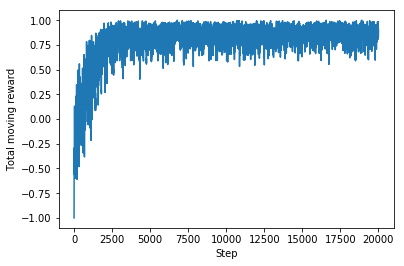

In [11]:
avg_moving_reward = TRPO_model.moving_rewards
plt.plot(np.arange(len(avg_moving_reward)), avg_moving_reward)
plt.xlabel('Step')
plt.ylabel('Total moving reward')
plt.show()

# 2) NMF

In [12]:
import time

## a) ADMM

In [13]:
def threshold(M,t=0):
    d,q = np.shape(M)
    for i in range(d):
        for j in range(q):
            M[i,j] = max(M[i,j],t)
    return M
    

def nmf_admm_KL(V,W,H,rho,N):
    t_begin = time.time()
    objectif = np.zeros(N)
    times = np.zeros(N)
    eps = 1e-5
    
    m,n = np.shape(V)
    _,k = np.shape(W)
        
    X = np.dot(W,H)
    Wp = W
    Hp = H
    alphaX = np.zeros(np.shape(X))
    alphaW = np.zeros(np.shape(W))
    alphaH = np.zeros(np.shape(H))
    
    for i in range(N):
        # update H
        H = np.dot(np.linalg.inv(np.dot(np.transpose(W),W)+np.eye(k)),np.dot(np.transpose(W),X)
                   + Hp + (1/rho)*( np.dot(np.transpose(W),alphaX)-alphaH ) )
        
        # update W
        A = np.dot(H,np.transpose(H)) + np.eye(k)
        B = np.dot(H,np.transpose(X)) + np.transpose(Wp) + (1/rho)*(np.dot(H,np.transpose(alphaX))-np.transpose(alphaW) )
        W = np.transpose( np.dot( np.linalg.inv(A) , B))
        
        # update X
        b = rho * np.dot(W,H) - alphaX - 1
        X = (b + np.sqrt(b**2 + 4 *rho*V))/(2*rho)
        
        # update for H+ and W+
        Hp = threshold(H + (1/rho)*alphaH,0)
        Wp = threshold(W + (1/rho)*alphaW,0)
        
        # update dual variables
        alphaX += rho*(X-np.dot(W,H))
        alphaH += rho*(H-Hp)
        alphaW += rho*(W-Wp)
        
        objectif[i] = np.sum(-V*(np.log((np.dot(Wp,Hp)+eps) / (V+eps))+1) + np.dot(Wp,Hp))
        times[i] = time.time() - t_begin

    return(Wp, Hp, objectif, times)

## b) MUA

In [14]:
def nmf_mua_KL(V, W, H, N):
    t_begin = time.time()
    objectif = np.zeros(N)
    times = np.zeros(N)
    eps = 1e-5
    
    m,n = np.shape(V)
    _,k = np.shape(W)
    
    for i in range(N):
        Hsumtemp = np.sum(H,axis=1)+eps
        Hsumtemp = Hsumtemp.reshape(1,-1)
        W = W * (np.dot(V / (np.dot(W,H)+eps) , np.transpose(H))) / np.tile( Hsumtemp, (m,1))
        
        Wsumtemp = np.sum(W,axis=0)+eps
        Wsumtemp = Wsumtemp.reshape(-1,1)
        H = H * (np.dot( np.transpose(W), V / (np.dot(W,H)+eps))) / np.tile( Wsumtemp, (1,n))
        
        objectif[i] = np.sum(-V*(np.log((np.dot(W,H)+eps) / (V+eps))+1) + np.dot(W,H))
        times[i] = time.time() - t_begin
    return(W, H, objectif, times)

## c) FPA

In [39]:
def nmf_fpa_KL(V, W, H, N, ND):
    
    # ND represents the number of iteration for each ND problem
    t_begin = time.time()
    objectif = []
    times = []
    
    m,n = np.shape(V)
    r,_ = np.shape(H)
    eps = 1e-7
    Wb = W
    Wold = W
    Hb = H
    Hold = H
    C = - V / np.dot(W,H)
    P = -np.dot(np.transpose(W),C) * np.tile(1/ np.sum(W,axis=0).reshape(-1,1),(1,n))
    MP = np.max(P,axis=0)
    C = C * np.tile( (1/MP).reshape(1,-1),(m,1))
    
    for i in range(int(N/ND)):
        sigma = np.sqrt(n/r) * np.sum(W) / (np.linalg.norm(W) * np.sum(V,axis=0))
        tau = np.sqrt(r/n) * np.sum(V,axis=0) / (np.linalg.norm(W) * np.sum(W))
        
        for j in range(ND):
            C += np.dot(W,Hb) * np.tile(sigma.reshape(1,-1),(m,1))
            C = 0.5 * C - 0.5 * np.sqrt(C**2 + V * 4 * np.tile(sigma.reshape(1,-1),(m,1)))
            H = threshold( H- np.dot(np.transpose(W),C+1) * np.tile(tau.reshape(1,-1),(r,1)))
            Hb = 2*H - Hold
            Hold = H
    
        sigma = np.sqrt(m/r) * np.sum(H) / (np.linalg.norm(H) * np.sum(V,axis=1))
        tau = np.sqrt(r/m) * np.sum(V,axis=1) / (np.linalg.norm(H) * np.sum(H))
        
        for j in range(ND):
            C += np.dot(Wb,H) * np.tile(sigma.reshape(-1,1),(1,n))
            C = 0.5 * C -0.5 * np.sqrt(C**2 + V * 4 * np.tile(sigma.reshape(-1,1),(1,n)))
            W = threshold( W - np.dot(C+1,np.transpose(H)) * np.tile(tau.reshape(-1,1),(1,r)))
            Wb = 2*W - Wold
            Wold = W
    
        for l in range(ND):
            objectif.append(np.sum(-V*(np.log((np.dot(W,H)+eps) / (V+eps))+1) + np.dot(W,H)))
        times.append(time.time() - t_begin)
    return(W, H, np.array(objectif), np.array(times))

In [48]:
n, m, r = 200, 500, 10
N = 1000

np.random.seed(0)
# construction of the matrices
W = np.abs(np.random.normal(0,1,(n,r)))
H = np.abs(np.random.normal(0,1,(r,m)))
V = np.dot(W,H)

# initialization
Wini = np.random.rand(n,r)
Hini = np.random.rand(r,m)

In [54]:
## ADMM
rho = 10
W1,H1,objectifs1,times1 = nmf_admm_KL(V, Wini, Hini, rho, N)

In [55]:
## MUA
W2, H2, objectifs2, times2 = nmf_mua_KL(V, Wini, Hini, N)

In [56]:
## FPA
ND = 5
W3, H3, objectifs3, times3 = nmf_fpa_KL(V, Wini, Hini, N, ND)

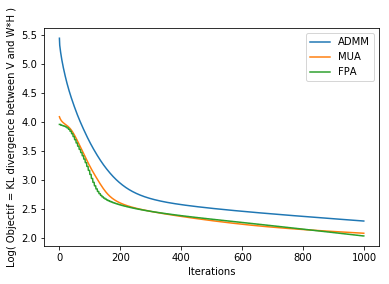

In [57]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(np.log10(objectifs1),label='ADMM')
plt.plot(np.log10(objectifs2),label='MUA')
plt.plot(np.log10(objectifs3),label='FPA')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Log( Objectif = KL divergence between V and W*H )')
plt.savefig('nmf.png')
plt.show()

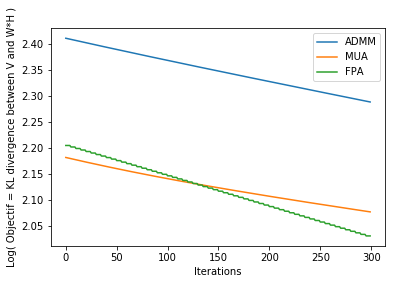

In [61]:
plt.figure(2)
plt.plot(np.log10(objectifs1[700:]),label='ADMM')
plt.plot(np.log10(objectifs2[700:]),label='MUA')
plt.plot(np.log10(objectifs3[700:]),label='FPA')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Log( Objectif = KL divergence between V and W*H )')
plt.savefig('nmf_precis.png')
plt.show()